## Perform analysis of neuronal cells from total and CD45+ cells

Catherine L. Worth

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import glob
import bbknn
import os, fnmatch
import requests
import io
import seaborn as sns
import scipy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 120, color_map = 'RdBu_r')

/gnu/var/guix/profiles/custom/huebner-sc/.guix-profile/lib/python3.7/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),


In [2]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5, scatter_size=4):
    def colored_scatter(x, y, c=None, scatter_size=scatter_size):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs, s=scatter_size)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True
        )

    plt.legend(legends)

In [3]:
def regress_batch(adata, batch_key, alpha = 1.0):
    from sklearn.linear_model import Ridge
    dummy = pd.get_dummies(adata.obs[[batch_key]], drop_first = False)
    X_exp = adata.X # scaled data
    LR = Ridge(fit_intercept = False, alpha = alpha)
    LR.fit(dummy, X_exp)
    X_correct = X_exp - LR.predict(dummy)
    adata.X = X_correct

In [4]:
def makevector_topmarkers(anndata, top_n, ldFC_cutoff=0.5, pvals_adj_cutoff=10**-30):
    results=anndata.uns['rank_genes_groups']
    clusters = results['names'].dtype.names
    top_genes=[]
    for cluster in clusters:
        topgenes_cluster=results['names'][cluster][np.where((results['logfoldchanges'][cluster]>=ldFC_cutoff) & (results['pvals_adj'][cluster]<(pvals_adj_cutoff)))][0:top_n]
        top_genes.extend(topgenes_cluster)
    return(top_genes)

In [5]:
def stacked_barplot_plain_region(adata, xaxis, stack, xaxis_label, legend_label, file_name, shift_top=0.2, xaxis_rotation=0):
    tmp=pd.crosstab(adata.obs[xaxis],
                adata.obs[stack]).sum(axis=1)
    ax= pd.crosstab(adata.obs[xaxis],
                    adata.obs[stack]).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0, width=0.22)

    lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=legend_label, frameon=False)
    plt.xlabel(xaxis_label)
    plt.ylabel('Percent Distribution')

    for xaxistick in range(ax.shape[0]):
        ax_1.text(xaxistick-shift_top,110,tmp[xaxistick],va='center', rotation=360)
    plt.xticks(rotation=xaxis_rotation)
    ax_1.grid(False)

    plt.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')

    plt.show()

In [6]:
def stacked_barplot_plain_donor(adata, xaxis, stack, xaxis_label, legend_label, file_name, shift_top=0.2, xaxis_rotation=0):
    tmp=pd.crosstab(adata.obs[xaxis],
                adata.obs[stack]).sum(axis=1)
    ax= pd.crosstab(adata.obs[xaxis],
                    adata.obs[stack]).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

    #display(ax)
    #plt.legend(title="Subject") # loc='upper center', bbox_to_anchor=(0.1, 1.0),
    lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=legend_label, frameon=False)
    plt.xlabel(xaxis_label)
    plt.ylabel('Percent Distribution')
    #for rec in ax_1.patches:
     #   height = rec.get_height()
        #ax_1.text(rec.get_x() + rec.get_width() / 2, rec.get_y() + height/2, "{:.0f}%".format(height),
        #       ha = 'center', va='center') #
    for xaxistick in range(ax.shape[0]):
        ax_1.text(xaxistick-shift_top,110,tmp[xaxistick],va='center', rotation=45)
    plt.xticks(rotation=xaxis_rotation)
    ax_1.grid(False)
    #ax_1.grid(which='major', alpha=0.5)
    #lat.grid(alpha=0.5, linestyle='solid')
    plt.savefig(file_name, bbox_extra_artists=(lgd,), bbox_inches='tight')

    plt.show()

In [7]:
def filter_by_expression(adata_obj, DE_column, key='rank_genes_groups'):

    def to_tensor(dataframe, columns = [], dtypes = {}, index = False):
        to_records_kwargs = {'index': index}
        if not columns:  # Default to all `dataframe.columns`
            columns = dataframe.columns
        if dtypes:       # Pull in modifications only for dtypes listed in `columns`
            to_records_kwargs['column_dtypes'] = {}
            for column in dtypes.keys():
                if column in columns:
                    to_records_kwargs['column_dtypes'].update({column: dtypes.get(column)})
        return dataframe[columns].to_records(**to_records_kwargs)
    
    gene_names = pd.DataFrame(adata_obj.uns[key]['names'])
    fraction_in_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    fraction_notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    in_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    notin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    allin_cluster_expr_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )
    allnotin_cluster_matrix = pd.DataFrame(
                np.zeros(gene_names.shape),
                columns=gene_names.columns,
                index=gene_names.index,
            )

    for cluster_number in fraction_in_cluster_matrix.columns:
        dummy=adata_obj.raw[:, adata_obj.uns['rank_genes_groups']['names'][cluster_number].tolist()]
        dummy.obs=adata_obj.obs
        subset_cluster=dummy[dummy.obs[DE_column].isin([cluster_number])]
        subset_notin_cluster=dummy[np.logical_not(dummy.obs[DE_column].isin([cluster_number]))]
        
   
        # Percent of cluster expressing
        if subset_cluster.shape[0] != 0:
            total_incluster=subset_cluster.shape[0]
        else: 
            total_incluster=np.nan

        if subset_notin_cluster.shape[0] != 0:
            total_outcluster=subset_notin_cluster.shape[0]
        else: 
            total_outcluster=np.nan
        
        fraction_in_cluster_matrix[cluster_number]=[(subset_cluster.X[:,gene_toanalyze].count_nonzero()/total_incluster) for gene_toanalyze in fraction_in_cluster_matrix.index]
        fraction_notin_cluster_matrix[cluster_number]=[(subset_notin_cluster.X[:,gene_toanalyze].count_nonzero()/total_outcluster) for gene_toanalyze in fraction_notin_cluster_matrix.index]

        # Expression level (only by expressed)
        in_cluster_expr_matrix[cluster_number]=[(subset_cluster.X[:,gene_toanalyze][subset_cluster.X[:,gene_toanalyze].nonzero()].mean()) for gene_toanalyze in in_cluster_expr_matrix.index]
        notin_cluster_matrix[cluster_number]=[(subset_notin_cluster.X[:,gene_toanalyze][subset_notin_cluster.X[:,gene_toanalyze].nonzero()].mean()) for gene_toanalyze in notin_cluster_matrix.index]
    
        # Expression_all in cluster
        allin_cluster_expr_matrix[cluster_number]=[(subset_cluster.X[:,gene_toanalyze].mean()) for gene_toanalyze in allin_cluster_expr_matrix.index]
        allnotin_cluster_matrix[cluster_number]=[(subset_notin_cluster.X[:,gene_toanalyze].mean()) for gene_toanalyze in allnotin_cluster_matrix.index]

    # Generate the last table results
    result = adata_obj.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    result['pc_cells_in'] = to_tensor(fraction_in_cluster_matrix)
    result['pc_cells_out'] = to_tensor(fraction_notin_cluster_matrix)
    result['expr_in'] = to_tensor(allin_cluster_expr_matrix)
    result['expr_out'] = to_tensor(allnotin_cluster_matrix)
    
    results =pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges', 'pc_cells_in', 'pc_cells_out', "expr_in", "expr_out"]})

    return results  

In [8]:
parent_path = '/fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/'
current_results_round = '20200629'

date_dir = parent_path + current_results_round + '/'

if not os.path.exists(date_dir):
    os.makedirs(date_dir, mode=0o775)

In [9]:
analysis = 'neuronal_cells'
analysis_dir = date_dir + analysis + "/"

if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir, mode=0o775)

In [10]:
results_dir = analysis_dir + 'Results/'

if not os.path.exists(results_dir):
    os.makedirs(results_dir, mode=0o775)

In [11]:
sc.settings.figdir = results_dir + 'Figures/'

if not os.path.exists(sc.settings.figdir):
    os.makedirs(sc.settings.figdir, mode=0o775)

In [12]:
tables_dir = results_dir + 'Tables/'

if not os.path.exists(tables_dir):
    os.makedirs(tables_dir, mode=0o775)

In [13]:
input_file = '/fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200423/global/Results/Subclusters/Heart_neuronal_cells_20200423_RAW.h5ad'
raw_filtered_file = results_dir + 'Bos_Cam_neuronal_cells_RAW_' + current_results_round + '_processed.h5ad'
results_file = results_dir + 'Bos_Cam_neuronal_cells_' + current_results_round + '_processed.h5ad'
bbknn_results_file = results_dir + 'Bos_Cam_neuronal_cells_' + current_results_round + '_bbknn.h5ad'

### Read in neuronal cell object

In [14]:
CB_BOS_nc = sc.read_h5ad(input_file)

In [15]:
CB_BOS_nc.shape

(4704, 33538)

Extract the total and CD45+ cell data

In [16]:
CB_BOS_cells = CB_BOS_nc[CB_BOS_nc.obs['cell_source'].isin(['Sanger-CD45', 'Sanger-Cells'])]

In [17]:
CB_BOS_cells.shape

(524, 33538)

### Sub-clustering of neuronal cells

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/violin_NC_cells_QC.png


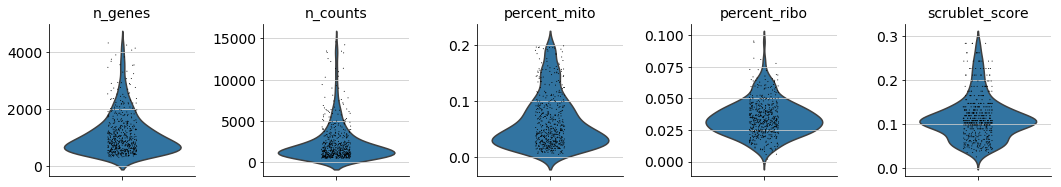

In [18]:
sc.pl.violin(CB_BOS_cells, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'],
             jitter=0.1, multi_panel=True, save = '_NC_cells_QC.png')

In [19]:
CB_BOS_cells.obs['center'] = CB_BOS_cells.obs['cell_source']

In [20]:
CB_BOS_cells.obs['center']
subs = {
    "Harvard-Nuclei":"Harvard",
    "Sanger-CD45":"Sanger",
    "Sanger-Cells":"Sanger",
    "Sanger-Nuclei":"Sanger",
     }

x=[subs.get(item,item)  for item in CB_BOS_cells.obs['center']]
CB_BOS_cells.obs['center']=x
pd.value_counts(CB_BOS_cells.obs['center'])


Sanger    524
Name: center, dtype: int64

... storing 'center' as categorical


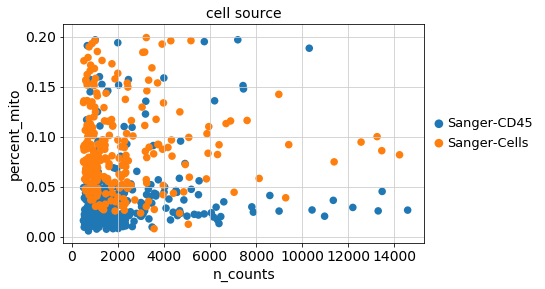

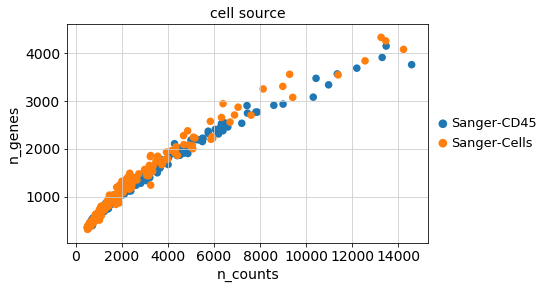

In [21]:
sc.pl.scatter(CB_BOS_cells, x='n_counts', y='percent_mito', color='cell_source')
sc.pl.scatter(CB_BOS_cells, x='n_counts', y='n_genes', color='cell_source')

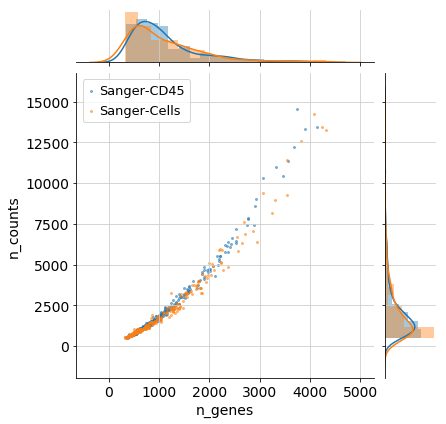

In [22]:
multivariateGrid('n_genes', 'n_counts', 'cell_source', CB_BOS_cells.obs, k_is_color=False, scatter_alpha=.5, scatter_size=4)

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/violin_NC_cells_QC_source.png


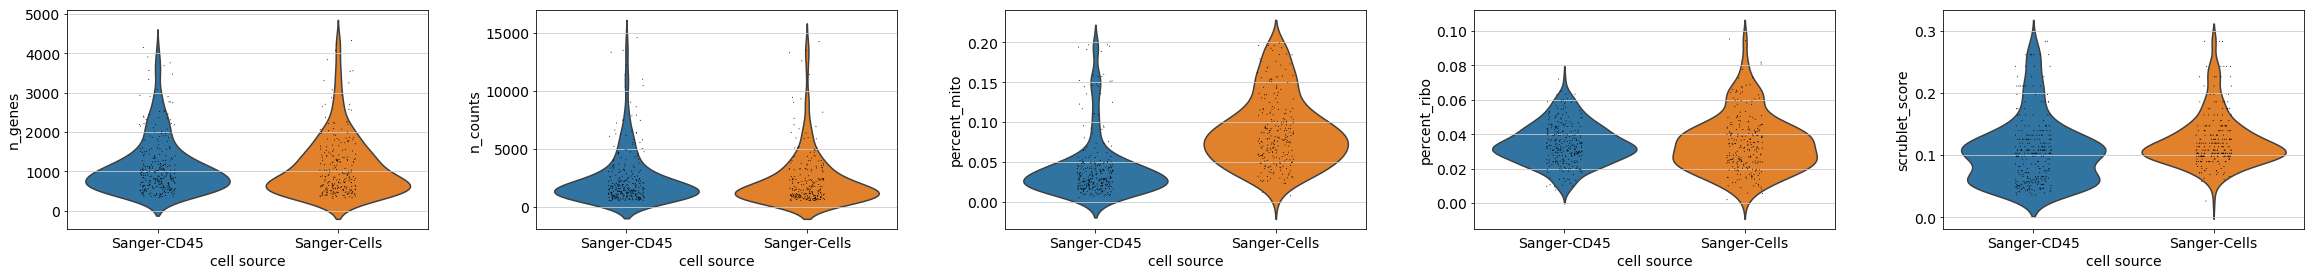

In [23]:
sc.pl.violin(CB_BOS_cells, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'],
             jitter=0.1, groupby ='cell_source', save = '_NC_cells_QC_source.png')

In [24]:
CB_BOS_cells.write(raw_filtered_file)

In [25]:
sc.pp.normalize_per_cell(CB_BOS_cells, counts_per_cell_after=1e4)

In [26]:
sc.pp.log1p(CB_BOS_cells)

In [27]:
CB_BOS_cells.raw = CB_BOS_cells

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


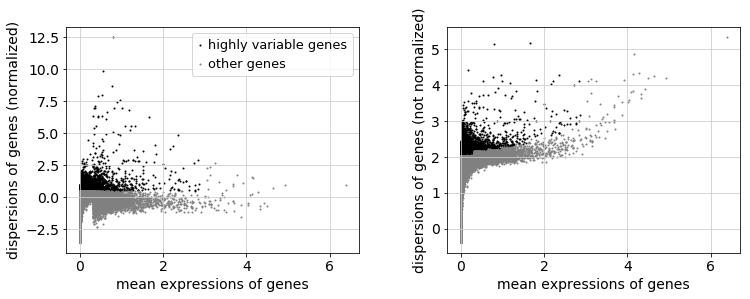

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:07.74)


(524, 4603)

In [28]:
sc.pp.highly_variable_genes(CB_BOS_cells)
sc.pl.highly_variable_genes(CB_BOS_cells)
cm_hvg = CB_BOS_cells[:, CB_BOS_cells.var['highly_variable']]
sc.pp.regress_out(cm_hvg, ['n_counts', 'percent_mito'])
sc.pp.scale(cm_hvg, max_value = 10)
cm_hvg.shape

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/pca_NC_cells_PCs.png


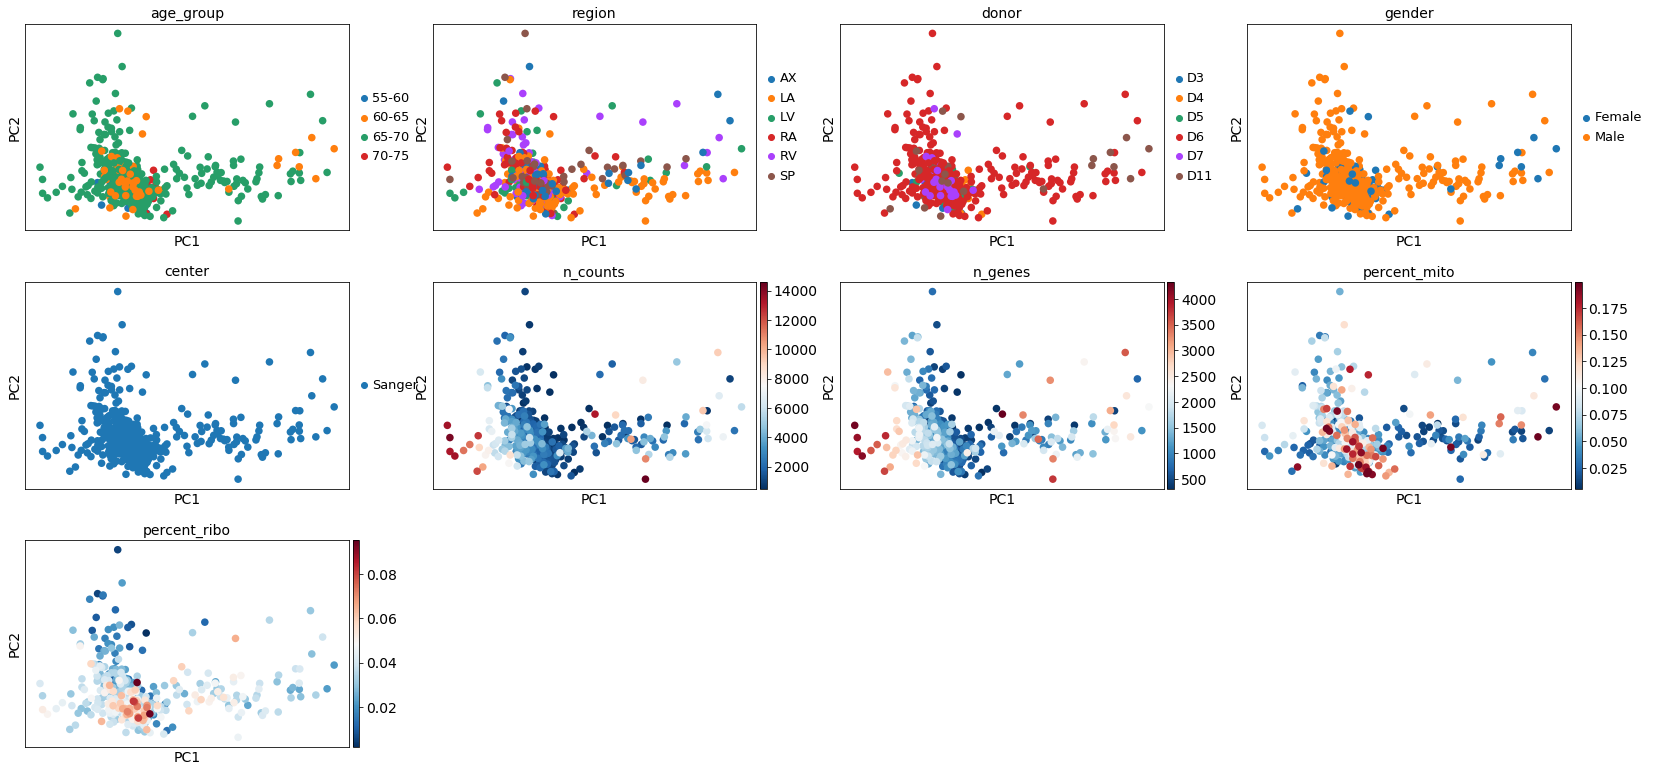

In [29]:
sc.tl.pca(cm_hvg, svd_solver = 'arpack', random_state = 100)
sc.pl.pca(cm_hvg, color = ['age_group', 'region', 'donor', 'gender', 'center', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo'],save='_NC_cells_PCs.png')

In [30]:
pd.value_counts(cm_hvg.obs['region'])

LA    193
RV     97
RA     97
SP     49
LV     49
AX     39
Name: region, dtype: int64

In [31]:
pd.value_counts(cm_hvg.obs['gender'])

Male      396
Female    128
Name: gender, dtype: int64

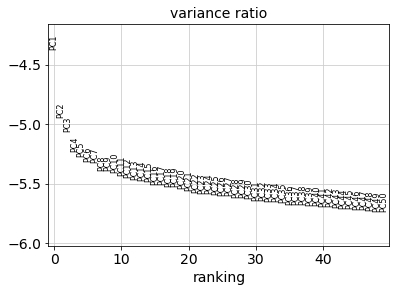

In [32]:
sc.pl.pca_variance_ratio(cm_hvg, log=True, n_pcs = 50)

In [33]:
nc_bbknn = cm_hvg.copy()
regress_batch(nc_bbknn, 'donor', alpha = 1.0)
sc.pp.pca(nc_bbknn, svd_solver = 'arpack', random_state = 100)
bbknn.bbknn(nc_bbknn, batch_key = 'donor',  neighbors_within_batch = 6)
sc.tl.umap(nc_bbknn, min_dist = 0.1, spread = 2, random_state = 100)

computing batch balanced neighbors
    finished (0:00:08.94) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:02.76) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [34]:
nc_bbknn.write(bbknn_results_file)

In [35]:
from IPython.display import display
from IPython.display import Image

In [36]:
sc.settings.set_figure_params(dpi = 120, color_map = 'RdBu_r')

running Leiden clustering
    finished (0:00:00.09) --> found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)
saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/umap_NC_cells_bbknn_resn_0.5.png


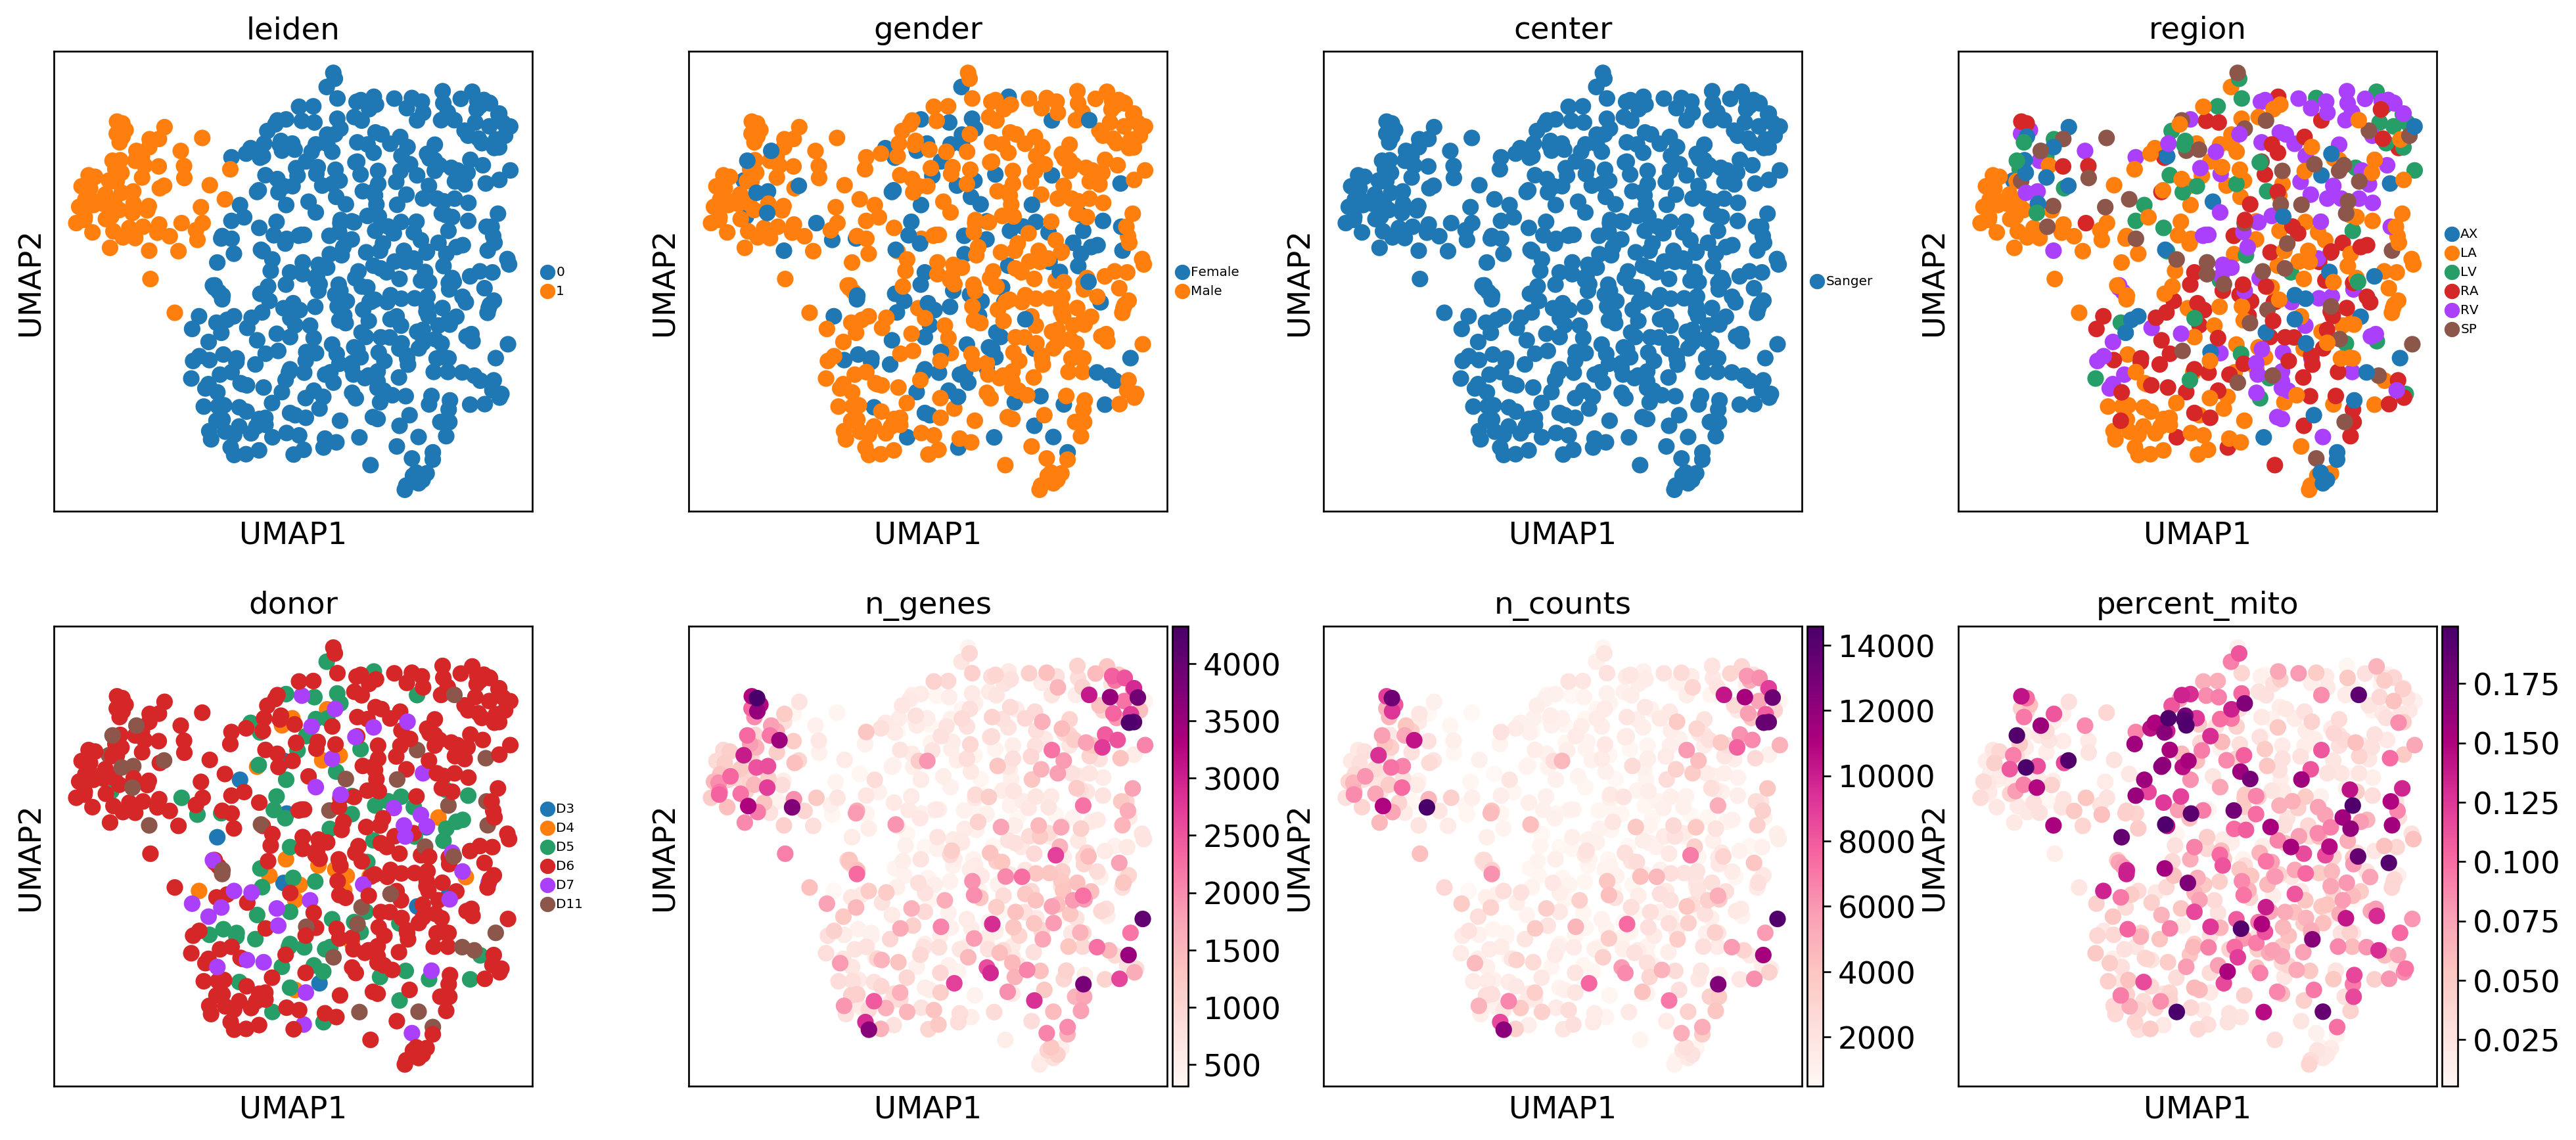

ranking genes
    finished (0:00:00.93) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/rank_genes_groups_leiden_NC_cells_resolution_0.5.png


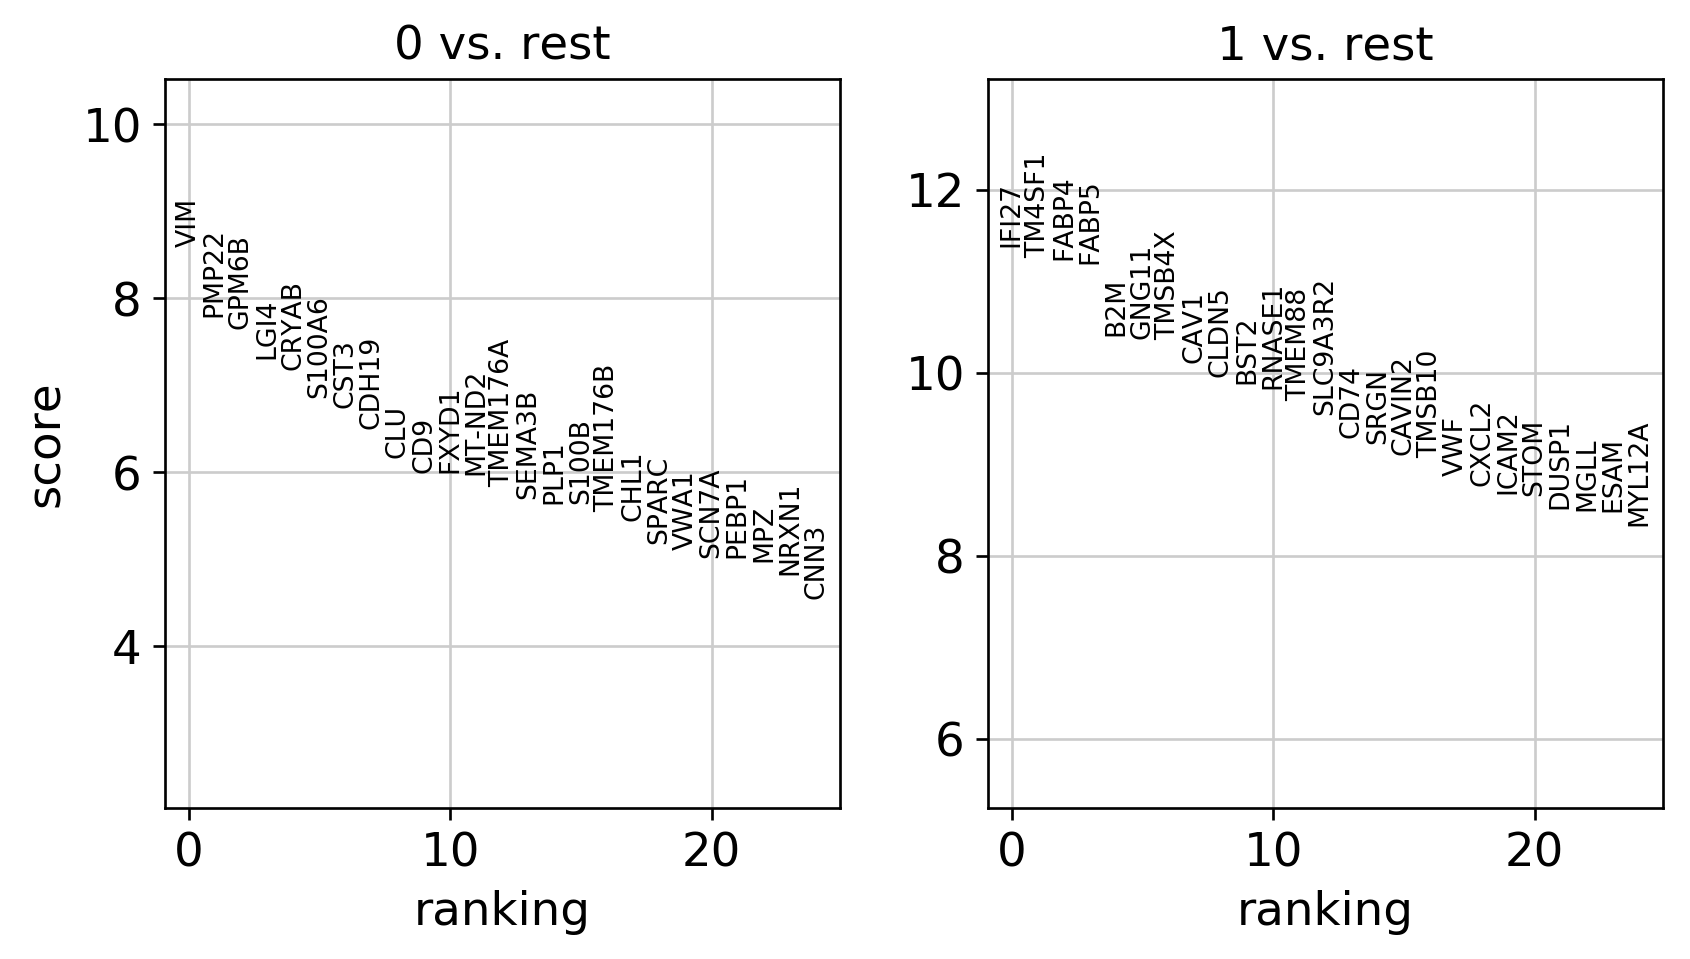

/gnu/var/guix/profiles/custom/huebner-sc/.guix-profile/lib/python3.7/site-packages/scipy/sparse/base.py:583: RuntimeWarning: divide by zero encountered in true_divide
  return self.astype(np.float_)._mul_scalar(1./other)


saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/dotplot_NC_cells_wilcox_marker_top10_0.5.png


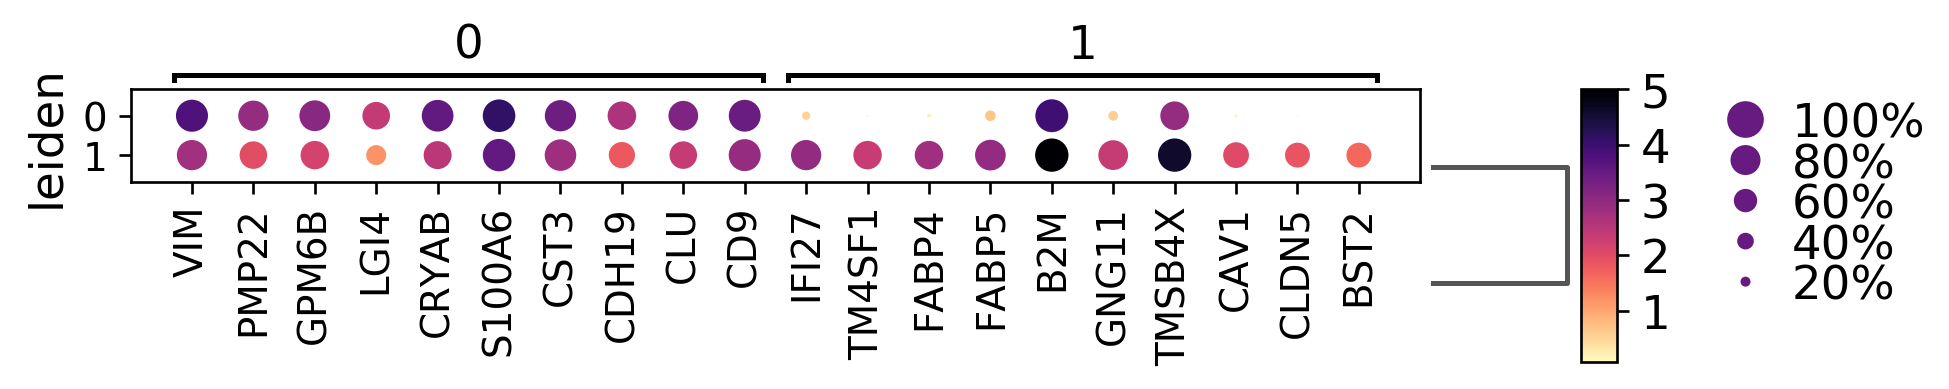

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/dotplot_NC_cells_wilcox_marker_top10_0.5_filtered.png


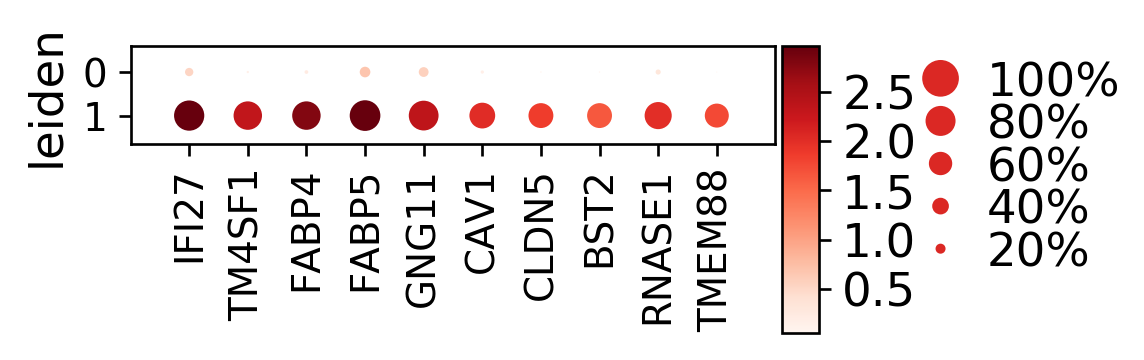

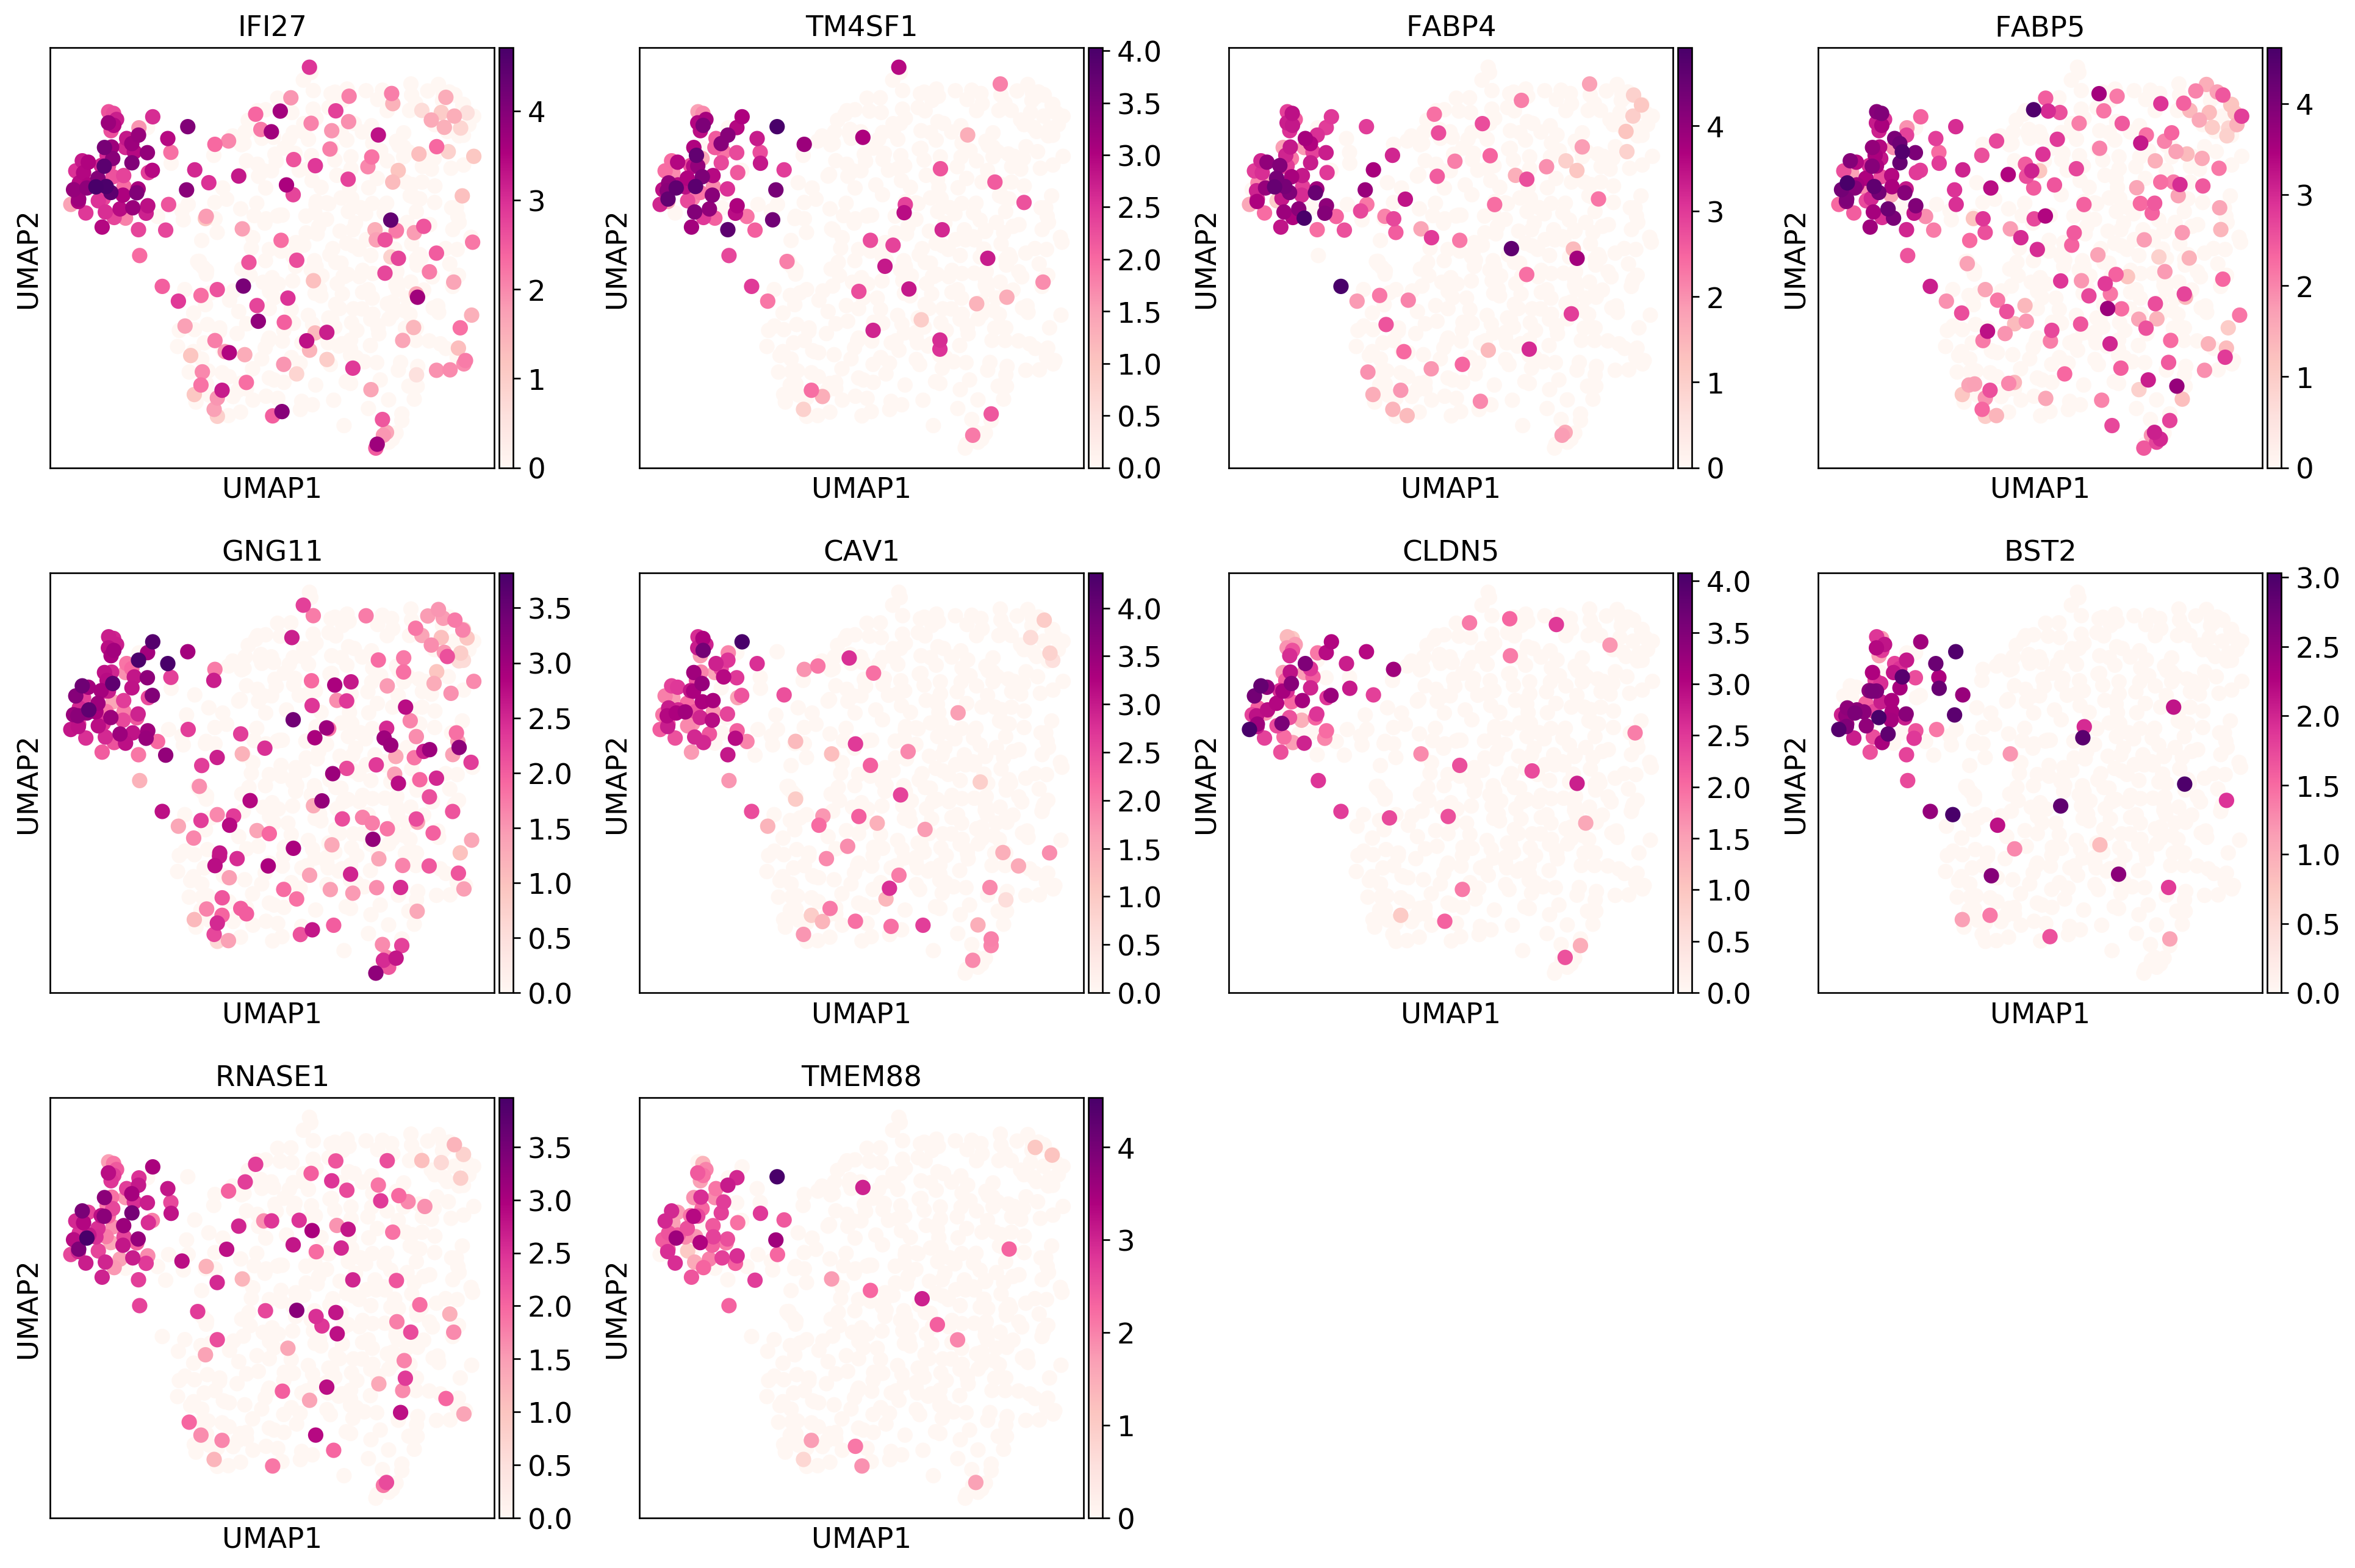

In [37]:
resolutions = ['0.5']
umap_array = []
dotplot_array = []
dotplot_filtered_array = []
for resolution in resolutions:
    sc.tl.leiden(nc_bbknn, resolution = float(resolution), random_state = 100)
    sc.pl.umap(nc_bbknn, color = ['leiden', 'gender', 'center', 'region', 'donor', 'n_genes', 'n_counts', 'percent_mito'], legend_fontsize = 6, save='_NC_cells_bbknn_resn_' + resolution + '.png', color_map = 'RdPu')
    leiden_name = 'leiden_' + resolution
    nc_bbknn.obs[leiden_name] = nc_bbknn.obs['leiden']
    sc.tl.rank_genes_groups(nc_bbknn, 'leiden', method = 'wilcoxon')
    sc.pl.rank_genes_groups(nc_bbknn, n_genes=25, sharey=False, save = "_NC_cells_resolution_" + resolution + ".png")
    i = Image(filename= sc.settings.figdir + "umap_NC_cells_bbknn_resn_" + resolution + ".png")
    umap_array.append(i)
    wilcox_clusters = filter_by_expression(nc_bbknn, 'leiden', key='rank_genes_groups')
    wilcox_clusters.to_csv(tables_dir + 'nc_bbknn_subclusters_wilcox_markers_' + resolution + '.csv')
    sc.pl.rank_genes_groups_dotplot(nc_bbknn, n_genes = 10, color_map = 'magma_r', save = '_NC_cells_wilcox_marker_top10_' + resolution + '.png')
    j = Image(filename= sc.settings.figdir + 'dotplot_NC_cells_wilcox_marker_top10_' + resolution + '.png')
    dotplot_array.append(j)
    

    
    sc.pl.dotplot(nc_bbknn,
              makevector_topmarkers(nc_bbknn, 10, ldFC_cutoff=0.8, pvals_adj_cutoff=10**-10),
              groupby='leiden', use_raw=True, save = '_NC_cells_wilcox_marker_top10_' + resolution + '_filtered.png')
    k = Image(filename= sc.settings.figdir + 'dotplot_NC_cells_wilcox_marker_top10_' + resolution + '_filtered.png')
    dotplot_filtered_array.append(k)
    
    current_list = makevector_topmarkers(nc_bbknn, 10, ldFC_cutoff=0.8, pvals_adj_cutoff=10**-10)
    sc.pl.umap(nc_bbknn, color = current_list, legend_fontsize = 6, color_map = 'RdPu')

    nc_bbknn.write(bbknn_results_file)

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/umap_NCs_cells_bbknn_leiden_region.png


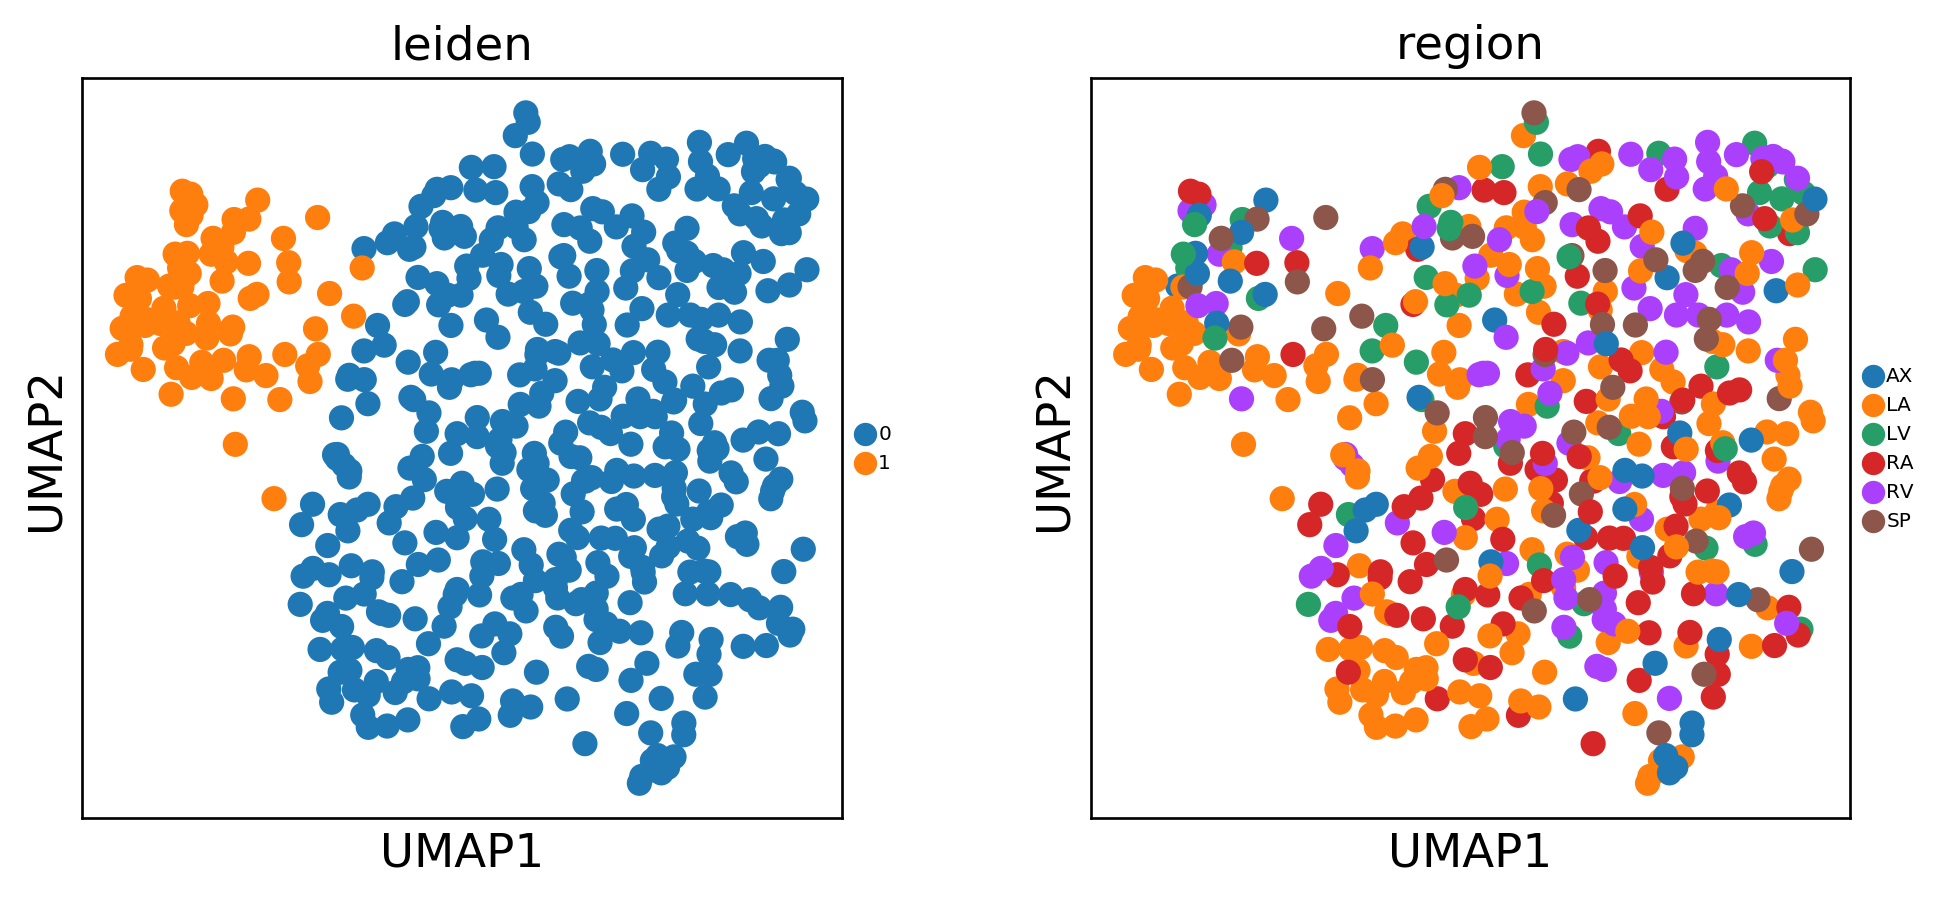

In [38]:
sc.pl.umap(nc_bbknn, color = ['leiden', 'region'], legend_fontsize = 6, save = "_NCs_cells_bbknn_leiden_region.png", color_map = 'RdPu')


In [39]:
nc_bbknn.write(bbknn_results_file)

Annotate clusters according to the annotations given to the neural cell clusters identified in nuclei

In [40]:
cm_cluster_names = [
    'NC1', 'NC6'
 
]
nc_bbknn.obs['cell_states'] = nc_bbknn.obs['leiden']
nc_bbknn.obs['cell_states'].cat.categories = cm_cluster_names

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/umap_NCs_cells_bbknn_named.png


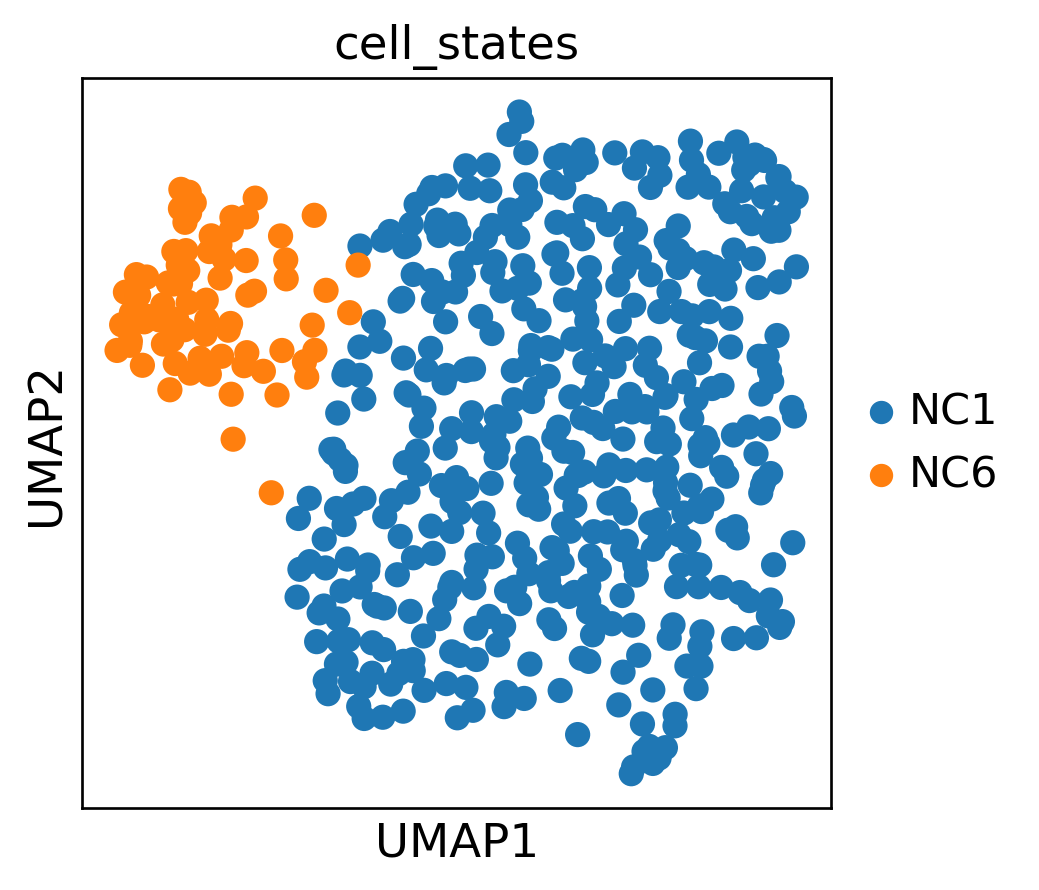

In [41]:
sc.pl.umap(nc_bbknn,color=['cell_states'], save = "_NCs_cells_bbknn_named.png", color_map = 'RdPu')

In [42]:
nc_bbknn.write(bbknn_results_file)

ranking genes
    finished (0:00:00.89) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


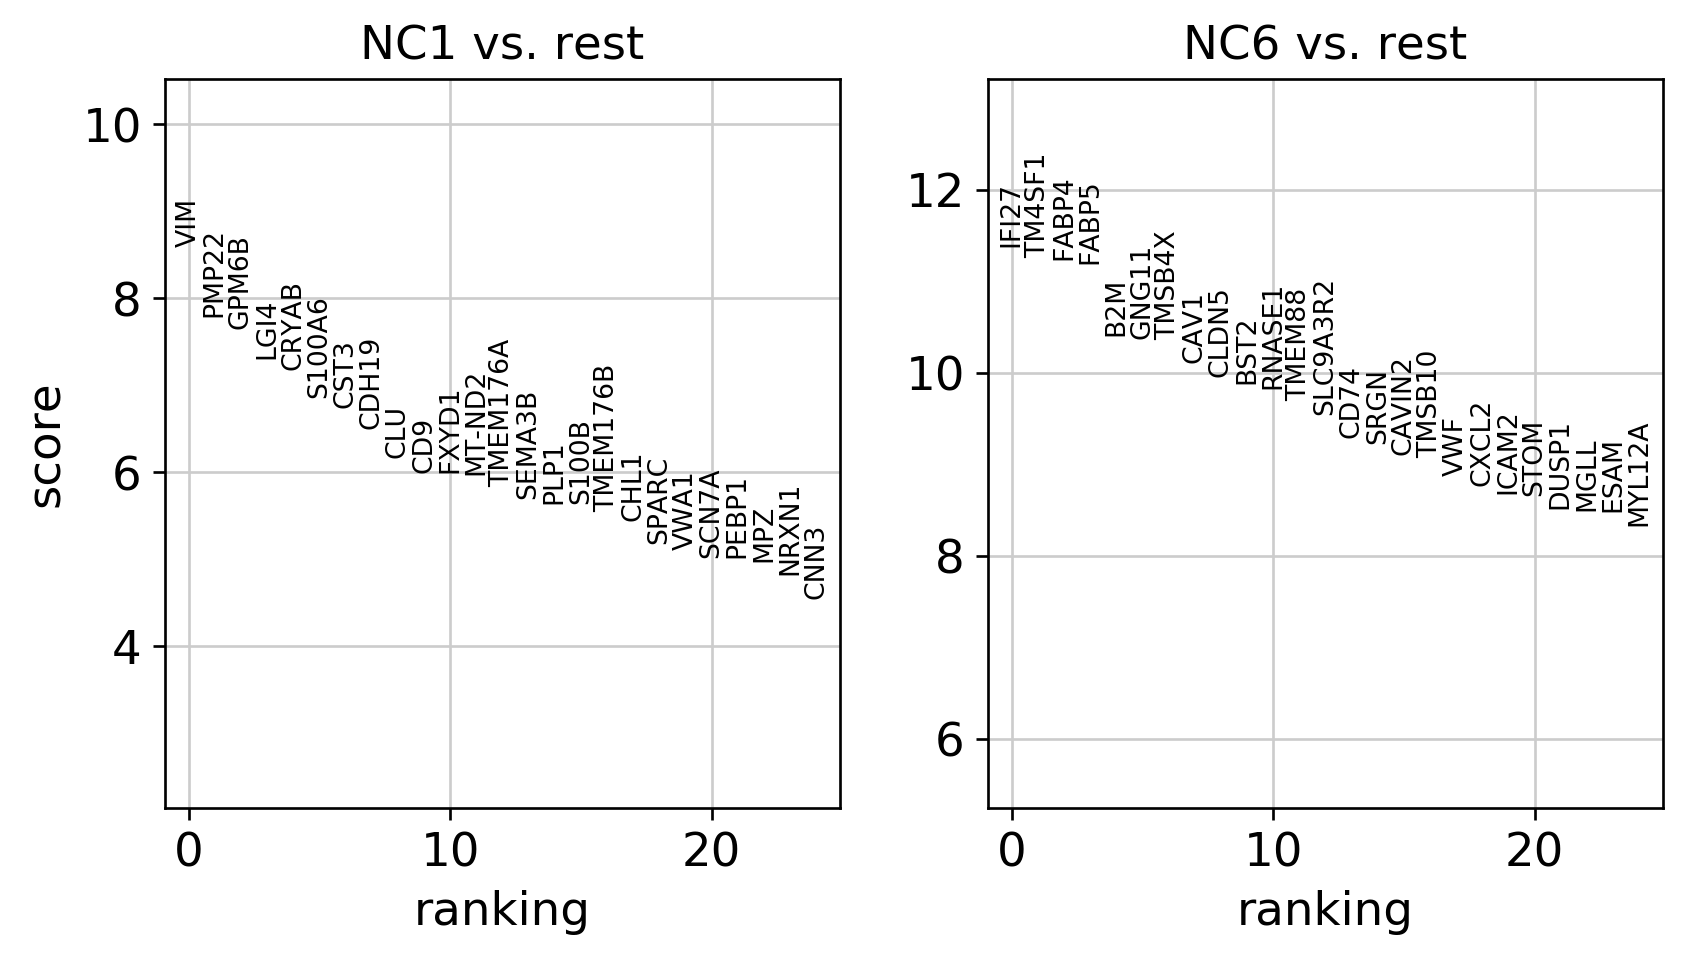

In [43]:
sc.tl.rank_genes_groups(nc_bbknn, 'cell_states', method = 'wilcoxon')
sc.pl.rank_genes_groups(nc_bbknn, n_genes=25, sharey=False)

In [44]:
wilcox_clusters = filter_by_expression(nc_bbknn, 'cell_states', key='rank_genes_groups')

In [45]:
wilcox_clusters.to_csv(tables_dir + 'NCs_cells_bbknn_subclusters_wilcox_markers_annotated.csv')

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/dotplot_NCs_cells_bbknn_subclusters_wilcoxon_markers_annotated.png


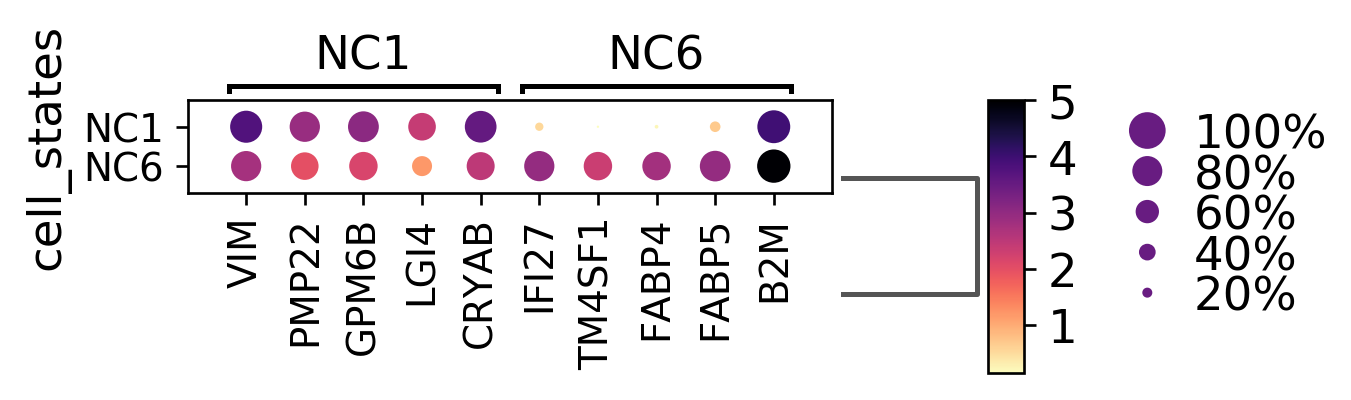

In [46]:
sc.pl.rank_genes_groups_dotplot(nc_bbknn, n_genes = 5, color_map = 'magma_r', save = "_NCs_cells_bbknn_subclusters_wilcoxon_markers_annotated.png")

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/dotplot_NCs_cells_bbknn_subclusters_wilcoxon_markers_annotated_filtered_10.png


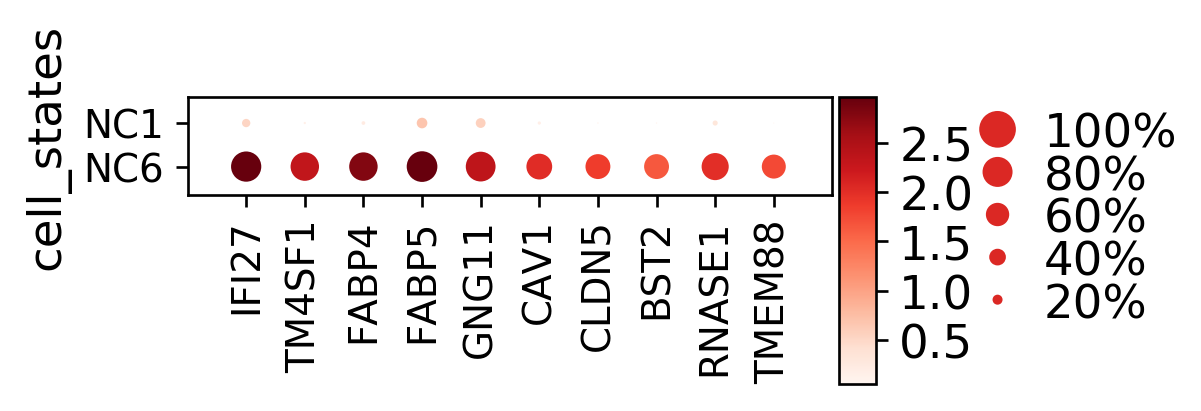

In [47]:
sc.pl.dotplot(nc_bbknn,
              makevector_topmarkers(nc_bbknn, 10, ldFC_cutoff=0.8, pvals_adj_cutoff=10**-10),
              groupby='cell_states', use_raw=True, save = "_NCs_cells_bbknn_subclusters_wilcoxon_markers_annotated_filtered_10.png")

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/dotplot_NCs_cells_bbknn_subclusters_wilcoxon_markers_annotated_filtered_5.png


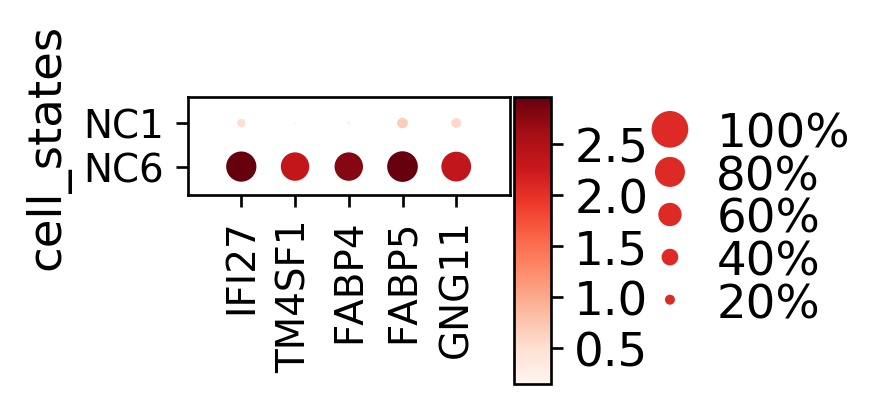

In [48]:
sc.pl.dotplot(nc_bbknn,
              makevector_topmarkers(nc_bbknn, 5, ldFC_cutoff=0.8, pvals_adj_cutoff=10**-10),
              groupby='cell_states', use_raw=True, save = "_NCs_cells_bbknn_subclusters_wilcoxon_markers_annotated_filtered_5.png")

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/umap_NC_cells_region.png


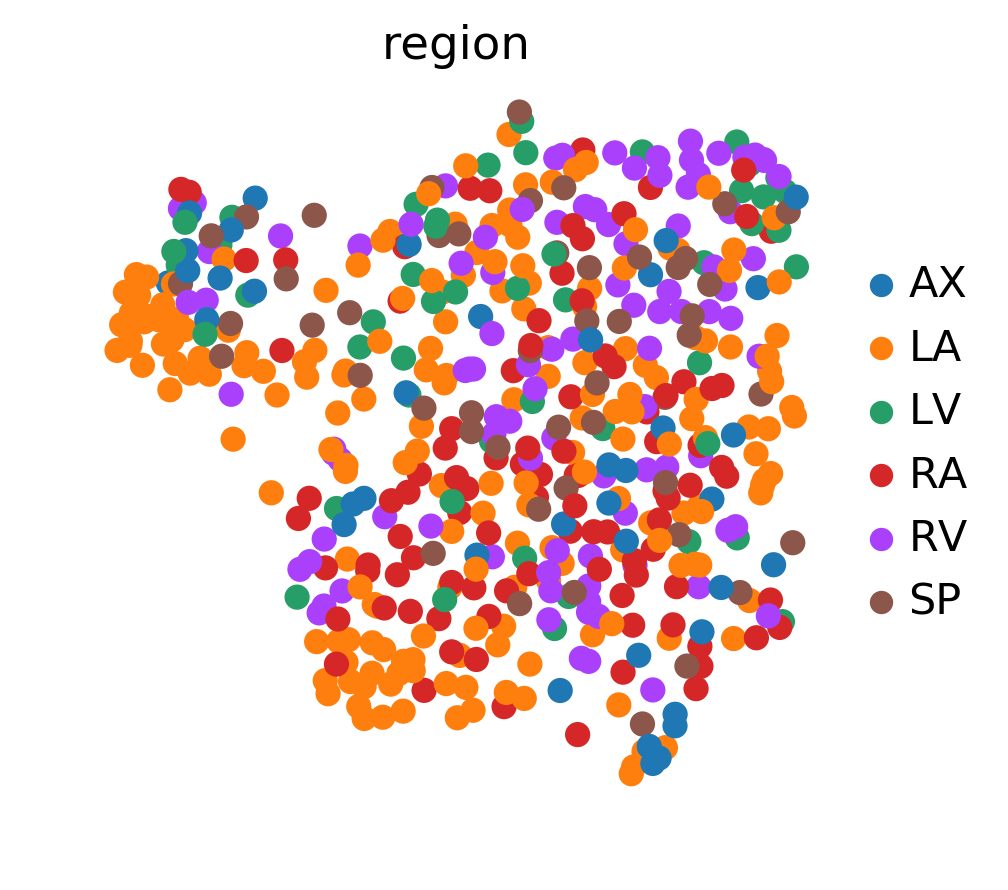

In [49]:
sc.pl.umap(nc_bbknn, color=["region"], frameon=False, save = '_NC_cells_region.png')

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/neuronal_cells/Results/Figures/umap_NC_cells_annotated.png


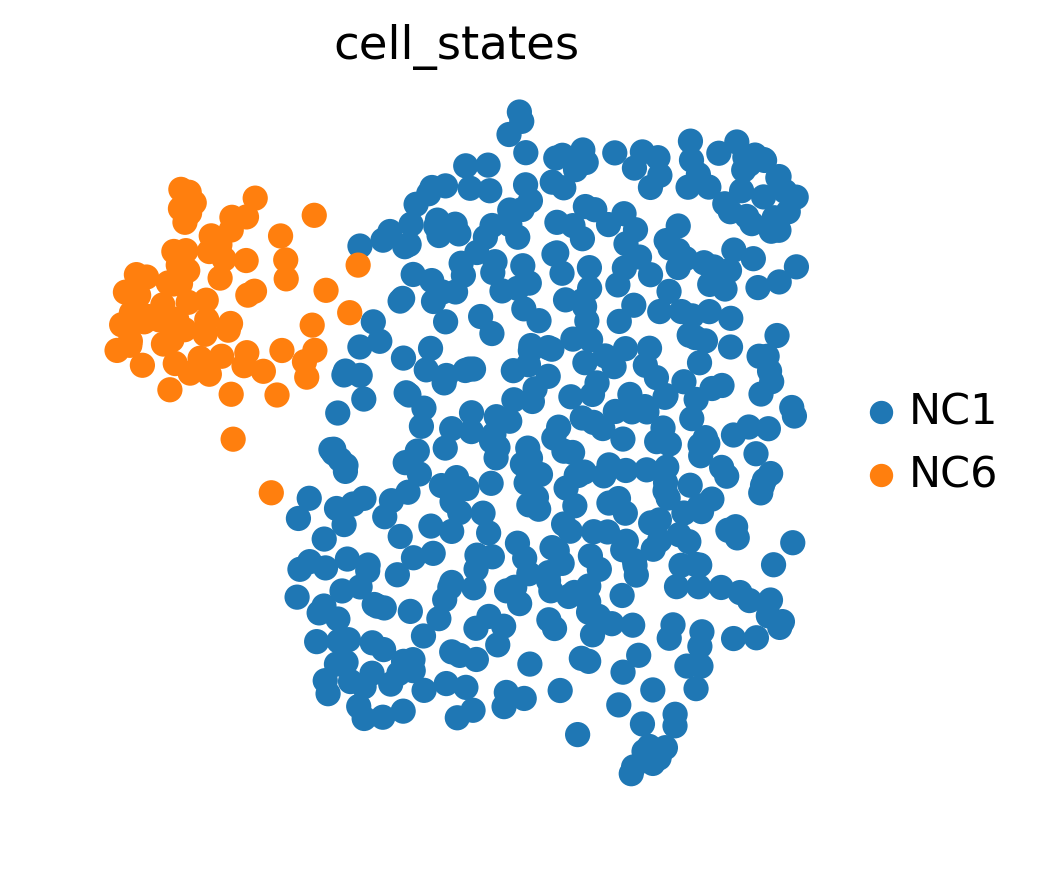

In [50]:
sc.pl.umap(nc_bbknn, color=["cell_states"], frameon=False, save = '_NC_cells_annotated.png')

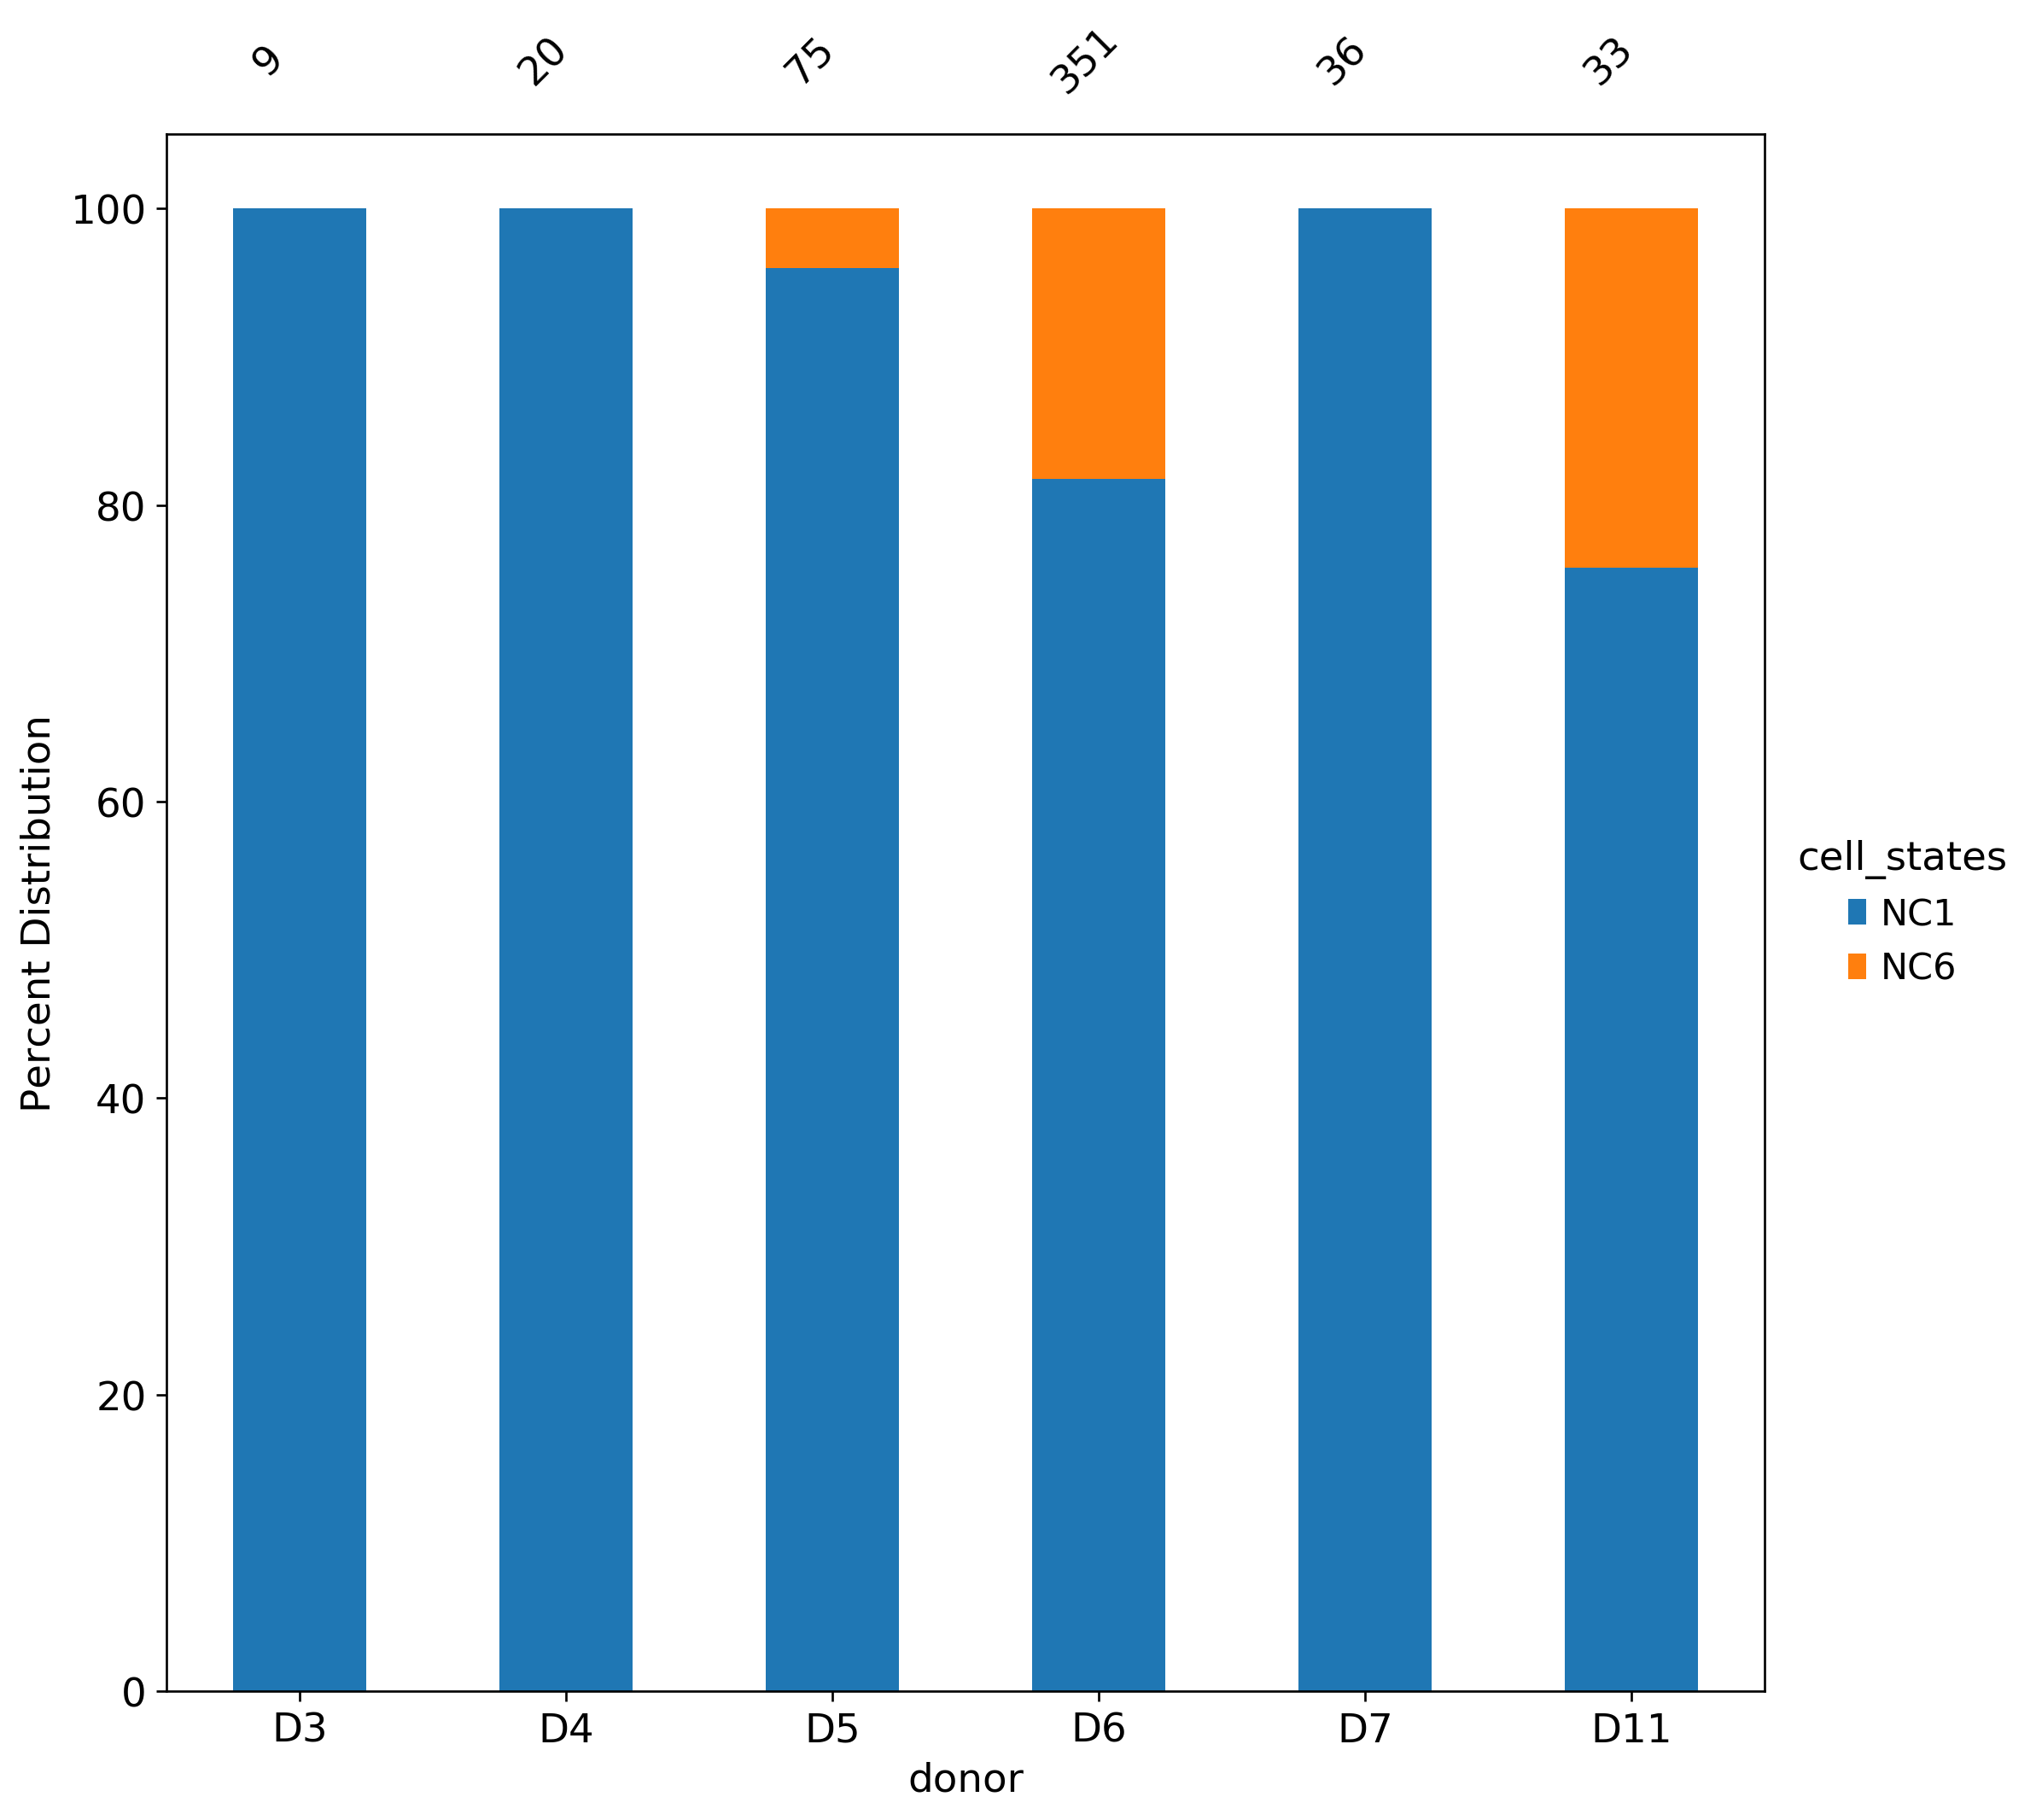

In [51]:
figname = sc.settings.figdir + 'NC_cells_donor_distribution_subclusters.png'
stacked_barplot_plain_donor(nc_bbknn, 'donor', 'cell_states', 'donor', 'cell_states', figname)

In [52]:
tab = pd.crosstab(nc_bbknn.obs['cell_states'],
nc_bbknn.obs['donor'])
tab

donor        D3  D4  D5   D6  D7  D11
cell_states                          
NC1           9  20  72  287  36   25
NC6           0   0   3   64   0    8

In [53]:
tab = pd.crosstab(nc_bbknn.obs['region'],
nc_bbknn.obs['cell_states'], normalize='index')
tab

cell_states       NC1       NC6
region                         
AX           0.769231  0.230769
LA           0.803109  0.196891
LV           0.857143  0.142857
RA           0.948454  0.051546
RV           0.927835  0.072165
SP           0.816327  0.183673

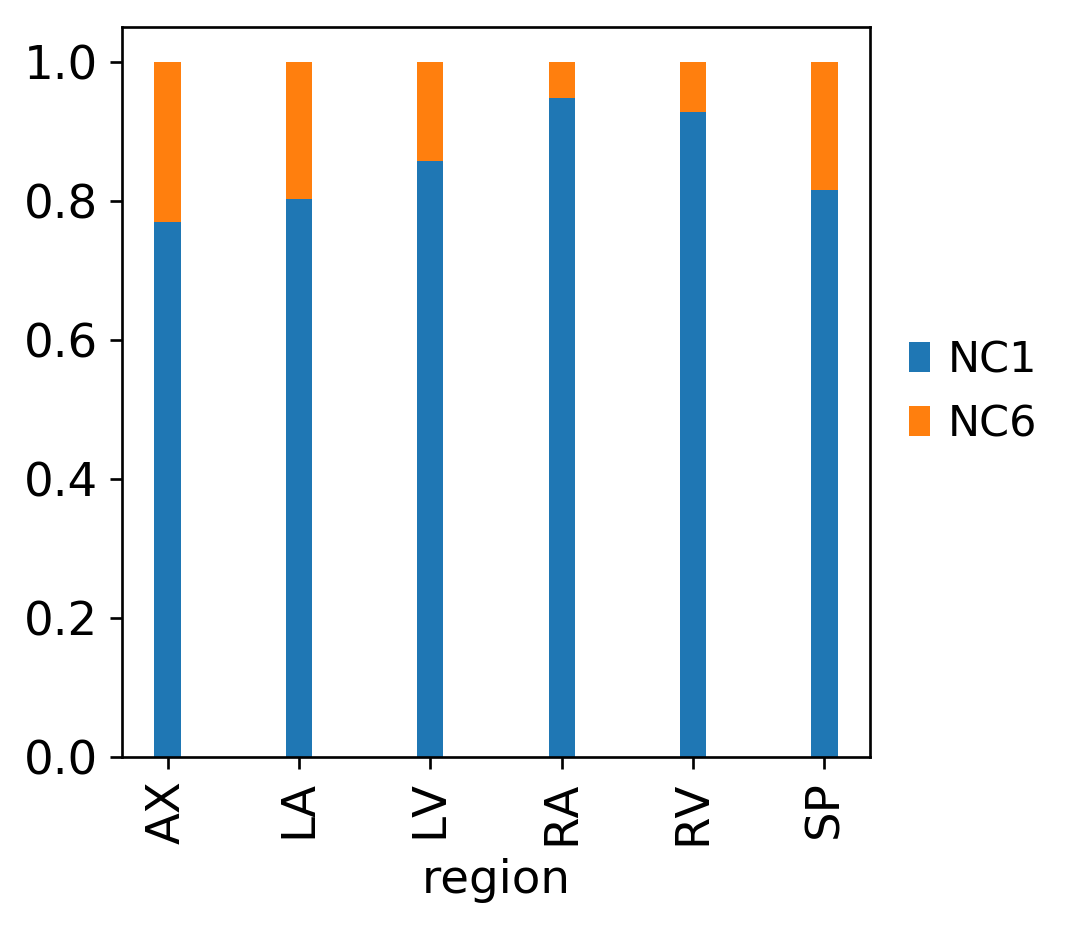

In [54]:
tab.plot.bar(stacked=True, width=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(b=None)
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.savefig(sc.settings.figdir + 'bar_chart_NC_cells_regions.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [55]:
nc_bbknn.write(bbknn_results_file)